In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
np.random.seed(42) # Set a fixed random seed

simulation_time = 1000  # Total simulation time
dt = 1.0  # Time step
time_steps = int(simulation_time / dt) # Simulation parameters

tau_m = 10.0  # Membrane time constant
V_rest = 0.0  # Initial membrane potential
V_reset = 0.0  # Reset potential
V_th = 0.5  # Threshold potential

A_plus = 0.051  # Synaptic potentiation amplitude
A_minus = 0.050  # Synaptic depression amplitude
tau_plus = 20.0  # Synaptic potentiation time constant
tau_minus = 20.0  # Synaptic depression time constant
w_max = 1.0  # Maximum synaptic weight
w_min = 0.2  # Minimum synaptic weight

num_inputs = 5 # Number of simulated neurons

In [10]:
def input_sequences():
    sequence = np.zeros((time_steps, num_inputs))
    spike_times = [0, 10, 20, 30, 40] # Time points for input spikes
    repeats = 20
    interval = 50
    # Create a 2D zero array to indicate that no spikes are fired by the input neurons initially
    # Then define a fixed set of spike time points where each neuron is forced to fire a spike
    # This set of spike times will be repeated 20 times during the training, with each repetition starting at intervals of 50 ms

    for r in range(repeats):
        for idx, t in enumerate(spike_times):
            time_idx = int((t + r * interval) / dt)
            if time_idx < time_steps:
                sequence[time_idx, idx] = 1
        # Calculate the time each spike should be forced to fire and record it in the sequence array

    return sequence

In [11]:
class LIFNeuron:
    def __init__(self):
        self.V = V_rest
        self.spike = False

    def update(self, I):
        dV = (-self.V + I) / tau_m * dt
        self.V += dV
        if self.V >= V_th:
            self.spike = True
            self.V = V_reset
        else:
            self.spike = False
        # If the threshold is reached, emit a spike and reset the membrane potential

In [12]:
class STDP:
    def __init__(self, num_pre, num_post):
        self.w = np.random.uniform(0.8, 1.0, (num_pre, num_post))  # Initialize weights
        self.tau_pre = tau_plus
        self.tau_post = tau_minus
        self.A_plus = A_plus
        self.A_minus = A_minus
        self.x_pre = np.zeros(num_pre)
        self.x_post = np.zeros(num_post)

    def update_weights(self, pre_spikes, post_spikes):
        self.x_pre *= np.exp(-dt / self.tau_pre)
        self.x_post *= np.exp(-dt / self.tau_post)
        # Apply exponential decay to the time traces of the presynaptic and postsynaptic neurons

        self.x_pre += pre_spikes
        self.x_post += post_spikes
        # Accumulate the time traces from the previous step and the current step

        dw = np.outer(self.A_plus * post_spikes, self.x_pre) - np.outer(self.x_post, self.A_minus * pre_spikes)
        # The first part, synaptic potentiation, is determined by the presynaptic time trace and postsynaptic spikes
        # The second part, synaptic depression, is determined by the postsynaptic time trace and presynaptic spikes

        self.w += dw.T
        self.w = np.clip(self.w, w_min, w_max)
        # Add the weight change (transposed) to the current weight matrix
        # Ensure the synaptic weights stay within the specified range through clipping

In [13]:
input_sequence = input_sequences()
output_neuron = LIFNeuron()
stdp = STDP(num_inputs, 1)
# Initialize and define the output neuron as 1

output_spikes = np.zeros(time_steps)
# Record whether the output neuron fires a spike

weights_over_step = np.zeros((time_steps, num_inputs))
# Record the weights at each time step; rows represent time steps, columns represent the weights of input neurons

V_membrane = np.zeros(time_steps)
# Record the membrane potential changes of the output neuron at each time step

for t in range(time_steps):
    input_spikes = input_sequence[t]
    I_syn = np.dot(stdp.w.T, input_spikes)[0] * 5.0
    # Calculate the synaptic current by taking the dot product of the weights and input neuron spikes,
    # then amplify the signal input intensity with a scaling factor

    output_neuron.update(I_syn)
    # Update the state of the output neuron

    output_spikes[t] = output_neuron.spike
    V_membrane[t] = output_neuron.V
    # Record whether a spike is fired at the current time step and the membrane potential

    stdp.update_weights(input_spikes, np.array([output_neuron.spike]))
    # Update the synaptic weights

    weights_over_step[t] = stdp.w[:, 0]
    # Record the weights at the current time step

output_spike_times = np.where(output_spikes == 1)[0] * dt
# Find the time points at which the output neuron fires spikes across all time steps

print("Times when the neuron fired spikes: ", output_spike_times)
print("Final synaptic weights: ", stdp.w.flatten())

Times when the neuron fired spikes:  [ 10.  30.  50.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240. 260.
 280. 300. 320. 340. 360. 380. 400. 420. 440. 460. 480. 500. 520. 540.
 560. 580. 600. 620. 640. 660. 680. 700. 710. 730. 750. 770. 790. 810.
 830. 850. 870. 890. 910. 930. 950. 970. 990.]
Final synaptic weights:  [0.98508063 0.98705937 0.96255351 0.93748825 0.84595857]


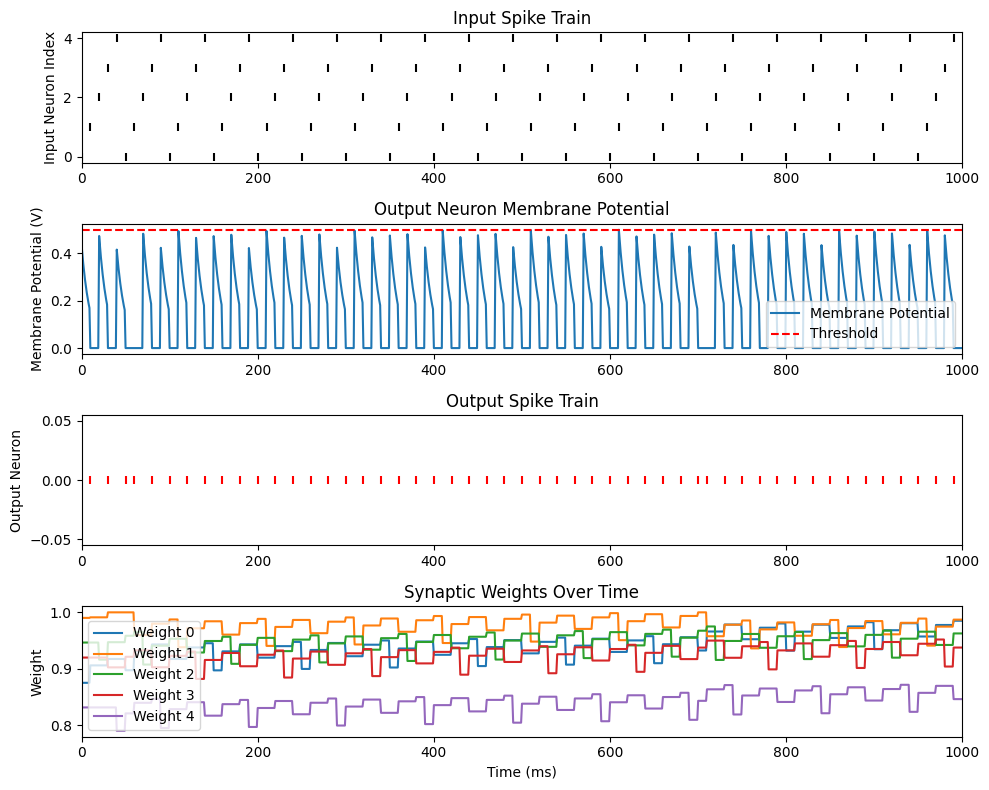

In [14]:
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
for i in range(num_inputs):
    spike_times = np.where(input_sequence[:, i] == 1)[0] * dt
    plt.scatter(spike_times, np.full_like(spike_times, i), marker='|', color='black')
plt.title('Input Spike Train')
plt.ylabel('Input Neuron Index')
plt.xlim(0, simulation_time)

plt.subplot(4, 1, 2)
plt.plot(np.arange(time_steps) * dt, V_membrane, label='Membrane Potential')
plt.plot(np.arange(time_steps) * dt, np.full(time_steps, V_th), 'r--', label='Threshold')
plt.title('Output Neuron Membrane Potential')
plt.ylabel('Membrane Potential (V)')
plt.xlim(0, simulation_time)
plt.legend()

plt.subplot(4, 1, 3)
spike_times = np.where(output_spikes == 1)[0] * dt
plt.scatter(spike_times, np.zeros_like(spike_times), marker='|', color='red')
plt.title('Output Spike Train')
plt.ylabel('Output Neuron')
plt.xlim(0, simulation_time)

plt.subplot(4, 1, 4)
for i in range(num_inputs):
    plt.plot(np.arange(time_steps) * dt, weights_over_step[:, i], label=f'Weight {i}')
plt.title('Synaptic Weights Over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Weight')
plt.legend()
plt.xlim(0, simulation_time)

plt.tight_layout()
plt.show()